<a href="https://colab.research.google.com/github/Mavitu56/SLMs/blob/main/SLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow Completo: Aprimoramento e Comparação de SLMs

Este notebook é a versão final, completa e funcional do plano para aprimorar e comparar um Small Language Model (SLM) usando Destilação de Conhecimento e Engenharia de Prompt.

In [1]:
# prompt: importar repositorio github

!git clone https://github.com/Mavitu56/SLMs.git

Cloning into 'SLMs'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 56 (delta 10), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 24.71 MiB | 10.05 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (29/29), done.


### 1. Instalação e Importações Globais

In [2]:
!pip install torch transformers "datasets==2.19.0" evaluate peft accelerate ipywidgets bitsandbytes sentencepiece pandas matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 812.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
import re
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import Counter
from tqdm.notebook import tqdm
from datasets import load_dataset, Dataset
from evaluate import load
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from torch.optim import AdamW
import torch.nn.functional as F

### 2. Funções da Fase 0: Configuração do Ambiente

In [4]:
def configure_task_and_metrics():
    """Carrega o dataset e as métricas para a tarefa de avaliação."""
    print("--- Step 0.1: Configuring Task (SQuAD) and Metrics ---")
    validation_dataset = load_dataset("squad", split="validation")
    squad_metric = load("squad")
    print("Dataset e métricas carregados.")
    return validation_dataset, squad_metric

def load_model(model_id):
    """Carrega um modelo e seu tokenizador a partir de um ID."""
    print(f"\n--- Loading Model: {model_id} ---")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        # Adiciona um pad token se não existir, comum para modelos de geração
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        model = AutoModelForCausalLM.from_pretrained(
            model_id, device_map="auto", torch_dtype=torch.bfloat16
        )
        print("Modelo carregado com sucesso.")
        return model, tokenizer
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        return None, None

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

def load_model_quantized(model_id):
    """
    Carrega um modelo e seu tokenizador com quantização de 4-bit para economizar memória.
    """
    print(f"\\n--- Loading Quantized Model: {model_id} ---")

    # Configuração para carregar o modelo em 4-bit
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        if tokenizer.pad_token is None:
            # Muitos modelos de instrução não têm pad_token, use o eos_token
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            quantization_config=quantization_config,
            torch_dtype=torch.bfloat16 # Consistente com o compute_dtype
        )
        print("Modelo quantizado carregado com sucesso.")
        return model, tokenizer
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        return None, None

def prepare_datasets(validation_dataset):
    """Prepara todos os subconjuntos de dados necessários."""
    print("\n--- Step 0.4: Preparing Datasets ---")
    squad_train_full = load_dataset("squad", split="train")
    # Usamos um subset menor para o KD Transfer para agilizar o treinamento
    kd_transfer_set = squad_train_full.shuffle(seed=42).select(range(10000))
    icl_cot_set = squad_train_full.select(range(5))
    datasets = {
        "evaluation": validation_dataset,
        "kd_transfer": kd_transfer_set,
        "icl_cot_examples": icl_cot_set
    }
    print("Datasets preparados.")
    return datasets

### 3. Funções da Fase 1: Destilação de Conhecimento (KD)

In [5]:
class KDConfig:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    TEMPERATURE = 2.0
    LEARNING_RATE = 5e-5
    NUM_EPOCHS = 3 # Reduzido para uma execução mais rápida de exemplo. Aumente para 3 em um treino real.

# Pad logits até o mesmo comprimento (com zeros no final, que terão pouco peso na softmax)
def pad_to_len(logits, target_len):
    pad_len = target_len - logits.shape[1]
    if pad_len > 0:
        pad = torch.zeros((logits.shape[0], pad_len, logits.shape[2]), device=logits.device)
        logits = torch.cat([logits, pad], dim=1)
    return logits

# --- Técnica 1.1: KD Base (Logit Matching) ---
def compute_distillation_loss(student_logits, teacher_logits, temperature):
    """Calcula a perda de Destilação de Conhecimento (KL Divergence)."""
    soft_teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
    soft_student_log_probs = F.log_softmax(student_logits / temperature, dim=-1)
    distillation_loss = F.kl_div(soft_student_log_probs, soft_teacher_probs, reduction='batchmean')
    return (temperature**2) * distillation_loss

def run_base_kd_training(student_model, teacher_model, student_tokenizer, teacher_tokenizer, kd_dataset, config, output_dir):
    """Executa o loop de treinamento para a Destilação de Conhecimento base."""
    print(f"\n--- Running Base Knowledge Distillation -> saving to {output_dir} ---")
    lora_config = LoraConfig(r=16, lora_alpha=32, target_modules=["q_proj", "v_proj"], lora_dropout=0.05, bias="none", task_type=TaskType.CAUSAL_LM)
    peft_student_model = get_peft_model(student_model, lora_config)
    optimizer = AdamW(peft_student_model.parameters(), lr=config.LEARNING_RATE)
    teacher_model.eval()

    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{config.NUM_EPOCHS}")
        peft_student_model.train()
        for batch in tqdm(kd_dataset.shuffle(seed=epoch).select(range(200)), desc=f"Epoch {epoch+1}"):
            prompt = f"Contexto: {batch['context']}\n\nPergunta: {batch['question']}"

            # Tokeniza os inputs
            teacher_inputs = teacher_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(config.DEVICE)
            student_inputs = student_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(config.DEVICE)

            # Gera os logits
            with torch.no_grad():
                teacher_logits = teacher_model(**teacher_inputs).logits
            student_logits = peft_student_model(**student_inputs).logits

            # Verifica compatibilidade de vocab
            if student_logits.shape[-1] != teacher_logits.shape[-1]:
                raise ValueError(
                    f"Os tamanhos dos vocabulários do estudante ({student_logits.shape[-1]}) e do professor ({teacher_logits.shape[-1]}) são diferentes. "
                    "A destilação de logits direta não é possível. Use a Destilação de Explicações."
                )

            # Pad para comprimento igual
            max_len = max(student_logits.shape[1], teacher_logits.shape[1])
            student_logits = pad_to_len(student_logits, max_len)
            teacher_logits = pad_to_len(teacher_logits, max_len)

            # Cálculo da loss e otimização
            loss = compute_distillation_loss(student_logits, teacher_logits, config.TEMPERATURE)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    peft_student_model.save_pretrained(output_dir)
    student_tokenizer.save_pretrained(output_dir)
    return peft_student_model
    print(f"Modelo destilado salvo em {output_dir}")


# --- Técnica 1.2: Destilação de Explicações ---
def generate_explanation_dataset(teacher_model, tokenizer, transfer_dataset):
    """Usa o modelo professor para gerar um dataset com raciocínios."""
    print("\n--- Generating Explanation-Augmented Dataset ---")
    prompt_template = "A partir do contexto, responda à pergunta. Explique seu raciocínio passo a passo e termine com a resposta final. Formato: [RACIOCÍNIO] ... <sep> [RESPOSTA] ...\n\nContexto: {context}\nPergunta: {question}"
    new_data = {"text": []}
    for example in tqdm(transfer_dataset.select(range(200)), desc="Generating Explanations"):
        full_prompt = prompt_template.format(context=example['context'], question=example['question'])
        inputs = tokenizer(full_prompt, return_tensors="pt").to(KDConfig.DEVICE)
        outputs = teacher_model.generate(**inputs, max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        new_data["text"].append(generated_text)
    return Dataset.from_dict(new_data)

from transformers import DataCollatorForLanguageModeling # Importe o DataCollator correto

def run_explanation_kd_training(student_model, tokenizer, explanation_dataset, config, output_dir):
    """
    Treina o estudante para gerar as explicações do professor (VERSÃO CORRIGIDA).
    """
    print(f"--- Running Explanation Distillation -> saving to {output_dir} ---")

    # PASSO 1: Tokenizar o dataset de texto
    # Esta função converte a coluna 'text' nas colunas 'input_ids' e 'attention_mask'
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=1024)

    print("Tokenizando o dataset...")
    # O .map() aplica a função a todo o dataset.
    # remove_columns remove a coluna de texto original, que não é mais necessária.
    tokenized_dataset = explanation_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=explanation_dataset.column_names
    )
    print("Dataset tokenizado com sucesso.")


    # PASSO 2: Usar um Data Collator para Language Modeling
    # O DataCollator agrupa os exemplos em lotes, aplica preenchimento (padding)
    # e, crucialmente, cria a coluna 'labels' a partir dos 'input_ids'.
    # mlm=False é para Causal Language Models (GPT, Llama, etc.).
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


    # Configuração do LoRA e do PEFT (como você já tinha)
    lora_config = LoraConfig(r=16, lora_alpha=32, target_modules=["q_proj", "v_proj"], lora_dropout=0.05, bias="none", task_type=TaskType.CAUSAL_LM)
    peft_student_model = get_peft_model(student_model, lora_config)

    training_args = TrainingArguments(
        output_dir=f"./results/explanation_training_checkpoints", # Diretório para checkpoints
        num_train_epochs=config.NUM_EPOCHS,
        learning_rate=config.LEARNING_RATE,
        report_to="none",
        per_device_train_batch_size=4, # Adicione para evitar problemas de memória
        gradient_accumulation_steps=4 # Adicione para simular um batch size maior
    )

    # Instancie o Trainer com o dataset tokenizado e o data_collator
    trainer = Trainer(
        model=peft_student_model,
        args=training_args,
        train_dataset=tokenized_dataset, # Use o dataset tokenizado
        data_collator=data_collator,     # Use o DataCollator
        # O argumento tokenizer aqui é opcional nas versões mais recentes,
        # pois o collator já o possui.
    )

    # Inicie o treinamento
    print("Iniciando o treinamento com o Trainer...")
    trainer.train()
    print("Treinamento concluído.")

    # Salve o modelo final treinado
    peft_student_model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Modelo de explicação destilada salvo em {output_dir}")

### 4. Funções da Fase 2: Avaliação com Engenharia de Prompt

In [6]:
def run_zero_shot_baseline(model, tokenizer, evaluation_dataset, metrics_calculator):
    """Executa a avaliação de baseline (Zero-Shot Simples)."""
    prompt = "Contexto: {context}\n\nPergunta: {question}\n\nResposta:"
    return run_generic_evaluation(model, tokenizer, evaluation_dataset, metrics_calculator, prompt, "Zero-Shot Baseline")

def run_few_shot_icl(model, tokenizer, evaluation_dataset, icl_examples, num_shots, metrics_calculator):
    """Executa a avaliação com In-Context Learning (Few-Shot)."""
    prefix = "".join([f"Contexto: {ex['context']}\nPergunta: {ex['question']}\nResposta: {ex['answers']['text'][0]}\n\n---\n\n" for ex in icl_examples.select(range(num_shots))])
    prompt = prefix + "Contexto: {context}\n\nPergunta: {question}\n\nResposta:"
    return run_generic_evaluation(model, tokenizer, evaluation_dataset, metrics_calculator, prompt, f"{num_shots}-Shot ICL")

def run_zero_shot_cot(model, tokenizer, evaluation_dataset, metrics_calculator):
    """Executa a avaliação com Zero-Shot Chain-of-Thought."""
    prompt = "Contexto: {context}\n\nPergunta: {question}\n\nPense passo a passo. A resposta final é:"
    return run_generic_evaluation(model, tokenizer, evaluation_dataset, metrics_calculator, prompt, "Zero-Shot CoT")

def run_self_consistency_cot(model, tokenizer, evaluation_dataset, metrics_calculator, num_paths=5):
    """Executa a avaliação com Auto-Consistência sobre o Zero-Shot CoT."""
    print(f"\n--- Running Self-Consistency ({num_paths} paths) ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    prompt_template = "Contexto: {context}\n\nPergunta: {question}\n\nPense passo a passo. A resposta final é:"

    predictions, references = [], []
    for example in tqdm(evaluation_dataset.select(range(20)), desc="Self-Consistency Eval"):
        prompt = prompt_template.format(context=example['context'], question=example['question'])
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        path_answers = []
        for _ in range(num_paths):
            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=150, do_sample=True, temperature=0.7, top_k=50, pad_token_id=tokenizer.eos_token_id)
            completion = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):].strip()
            match = re.search(r'A resposta final é:\s*(.*)', completion, re.IGNORECASE)
            if match: path_answers.append(match.group(1).strip())

        final_prediction = Counter(path_answers).most_common(1)[0][0] if path_answers else ""
        predictions.append({'id': example['id'], 'prediction_text': final_prediction})
        references.append({'id': example['id'], 'answers': example['answers']})
    return metrics_calculator.compute(predictions=predictions, references=references)

def run_generic_evaluation(model, tokenizer, eval_dataset, metrics_calculator, prompt_template, strategy_name, eval_subset_size=1000):
    """Função genérica que executa a avaliação para a maioria das estratégias de prompt."""
    print(f"\n--- Running Evaluation: {strategy_name} ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    predictions, references = [], []

    for example in tqdm(eval_dataset.select(range(eval_subset_size)), desc=f"Evaluating {strategy_name}"):
        prompt = prompt_template.format(context=example['context'], question=example['question'])
        inputs = tokenizer(prompt, return_tensors="pt", max_length=1536, truncation=True).to(device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=60, pad_token_id=tokenizer.eos_token_id)

        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predicted_answer = full_text[len(prompt):].strip()

        if "A resposta final é:" in prompt:
            match = re.search(r'A resposta final é:\s*(.*)', predicted_answer, re.IGNORECASE)
            predicted_answer = match.group(1).strip() if match else predicted_answer.split('\n')[-1].strip()

        predictions.append({'id': example['id'], 'prediction_text': predicted_answer})
        references.append({'id': example['id'], 'answers': example['answers']})

    return metrics_calculator.compute(predictions=predictions, references=references)

### 6. Execução do Pipeline (Modo Simulado)

A célula abaixo executa o pipeline em **modo de simulação**. Ela não treina nem avalia os modelos de verdade, mas gera um relatório com dados de exemplo para demonstrar a estrutura de análise. Para uma execução real, você deve primeiro executar as células de treinamento da Fase 1 e depois rodar o pipeline com `simulation_mode=False`.

In [9]:
# prompt: login hugging face

from huggingface_hub import notebook_login
notebook_login()

In [8]:
from peft import PeftModel
# --- FASE 0: SETUP ---
print("--- FASE 0: CONFIGURANDO AMBIENTE E DADOS ---")
validation_data, metrics_calc = configure_task_and_metrics()
prepared_data = prepare_datasets(validation_data)
config = KDConfig()

--- FASE 0: CONFIGURANDO AMBIENTE E DADOS ---
--- Step 0.1: Configuring Task (SQuAD) and Metrics ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset e métricas carregados.

--- Step 0.4: Preparing Datasets ---
Datasets preparados.


In [12]:
# --- FASE 1: TREINAMENTO (Opcional) ---
print("\n--- FASE 1: EXECUTANDO TREINAMENTO DOS MODELOS KD ---")
TEACHER_MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.2"
STUDENT_MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"


--- FASE 1: EXECUTANDO TREINAMENTO DOS MODELOS KD ---


In [11]:
# Carregue os modelos usando a nova função
teacher_model, teacher_tokenizer = load_model_quantized(TEACHER_MODEL_ID)
student_model, student_tokenizer = load_model_quantized(STUDENT_MODEL_ID)
teacher_model_ext = teacher_model
student_model_base = student_model

NameError: name 'TEACHER_MODEL_ID' is not defined

In [ ]:
# 1. Treina o modelo de KD Base
run_base_kd_training(
    student_model=student_model_base, teacher_model=teacher_model_ext, student_tokenizer=student_tokenizer, teacher_tokenizer=teacher_tokenizer,
    kd_dataset=prepared_data['kd_transfer'], config=config, output_dir="./results/kd_base_model"
)


--- Running Base Knowledge Distillation -> saving to ./results/kd_base_model ---

Epoch 1/3


Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]


Epoch 2/3


Epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]


Epoch 3/3


Epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Line

In [ ]:
# 2. Treina o modelo de Auto-Destilação (requer um professor "especialista")
print("\n--- Treinando professor para Auto-Destilação ---")
# A forma mais simples de criar um professor especialista é com um fine-tuning padrão.
# Aqui, vamos simular isso treinando o próprio estudante com KD por uma época.
specialist_teacher = run_base_kd_training(
    student_model=student_model_base, teacher_model=teacher_model_ext, student_tokenizer=student_tokenizer, teacher_tokenizer=teacher_tokenizer,
    kd_dataset=prepared_data['kd_transfer'], config=config, output_dir="./results/specialist_teacher_for_self_distillation"
)


--- Treinando professor para Auto-Destilação ---

--- Running Base Knowledge Distillation -> saving to ./results/specialist_teacher_for_self_distillation ---

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]


Epoch 2/3


Epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]


Epoch 3/3


Epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# ADAPTER_PATH = "results/specialist_teacher_for_self_distillation"
# print(f"Carregando adaptadores de: {ADAPTER_PATH}...")
# # A mágica acontece aqui: PeftModel aplica os adaptadores sobre o modelo base
# specialist_teacher = PeftModel.from_pretrained(student_model_base, ADAPTER_PATH)
# print("Adaptadores carregados e aplicados.")

In [ ]:
print("\n--- Executando Auto-Destilação ---")
run_base_kd_training(
    student_model=student_model_base, teacher_model=specialist_teacher, student_tokenizer=student_tokenizer, teacher_tokenizer=teacher_tokenizer,
    kd_dataset=prepared_data['kd_transfer'], config=config, output_dir="./results/kd_self_distilled_model"
)


--- Executando Auto-Destilação ---

--- Running Base Knowledge Distillation -> saving to ./results/kd_self_distilled_model ---

Epoch 1/3


Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]


Epoch 2/3


Epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]


Epoch 3/3


Epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Line

In [ ]:
# 3. Treina o modelo de Destilação de Explicações
explanation_dataset = generate_explanation_dataset(teacher_model_ext, teacher_tokenizer, prepared_data['kd_transfer'])

output_dataset_dir = "./explanation_dataset_saved"

print(f"Salvando o dataset em '{output_dataset_dir}'...")
# O método .save_to_disk() salva o dataset em formato Arrow para carregamento rápido
explanation_dataset.save_to_disk(output_dataset_dir)
print("Dataset salvo com sucesso!")


--- Generating Explanation-Augmented Dataset ---


Generating Explanations:   0%|          | 0/200 [00:00<?, ?it/s]

Salvando o dataset em './explanation_dataset_saved'...


Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset salvo com sucesso!


In [ ]:
# prompt: carregar dataset de um caminho

# Caminho para o diretório onde você salvou o dataset
output_dataset_dir = "/content/drive/MyDrive/content/content/explanation_dataset_saved"

# Carregue o dataset salvo do disco
print(f"Carregando o dataset salvo de '{output_dataset_dir}'...")
loaded_explanation_dataset = Dataset.load_from_disk(output_dataset_dir)
print("Dataset carregado com sucesso!")

explanation_dataset = loaded_explanation_dataset

Carregando o dataset salvo de '/content/drive/MyDrive/content/content/explanation_dataset_saved'...
Dataset carregado com sucesso!


In [ ]:
# prompt: upar pasta no drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# prompt: salvar pasta content no drive

!zip -r /content/results.zip /content/results/
!cp /content/results.zip /content/drive/MyDrive/
print("Pasta 'content' zipada e copiada para o Google Drive!")

  adding: content/results/ (stored 0%)
  adding: content/results/explanation_training_checkpoints/ (stored 0%)
  adding: content/results/kd_self_distilled_model/ (stored 0%)
  adding: content/results/kd_self_distilled_model/README.md (deflated 66%)
  adding: content/results/kd_self_distilled_model/tokenizer.model (deflated 55%)
  adding: content/results/kd_self_distilled_model/adapter_model.safetensors

In [ ]:
explanation_dataset[1]

{'text': 'A partir do contexto, responda à pergunta. Explique seu raciocínio passo a passo e termine com a resposta final. Formato: [RACIOCÍNIO] ... <sep> [RESPOSTA] ...\n\nContexto: The Ann Arbor Hands-On Museum is located in a renovated and expanded historic downtown fire station. Multiple art galleries exist in the city, notably in the downtown area and around the University of Michigan campus. Aside from a large restaurant scene in the Main Street, South State Street, and South University Avenue areas, Ann Arbor ranks first among U.S. cities in the number of booksellers and books sold per capita. The Ann Arbor District Library maintains four branch outlets in addition to its main downtown building. The city is also home to the Gerald R. Ford Presidential Library.\nPergunta: Ann Arbor ranks 1st among what goods sold?\n\n[RACIOCÍNIO] Ann Arbor is known for having a high number of booksellers and books sold per capita. Therefore, Ann Arbor ranks 1st among U.S. cities in the sales of b

In [ ]:
run_explanation_kd_training(
    student_model=student_model_base, tokenizer=student_tokenizer, explanation_dataset=explanation_dataset,
    config=config, output_dir="./results/explanation_distilled_model"
)
print("\n--- FASE DE TREINAMENTO CONCLUÍDA ---")

--- Running Explanation Distillation -> saving to ./results/explanation_distilled_model ---
Tokenizando o dataset...


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Dataset tokenizado com sucesso.
Iniciando o treinamento com o Trainer...


OutOfMemoryError: CUDA out of memory. Tried to allocate 220.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 26.12 MiB is free. Process 2676 has 14.71 GiB memory in use. Of the allocated memory 14.30 GiB is allocated by PyTorch, and 289.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
# --- FASE 2 & 3: AVALIAÇÃO E ANÁLISE ---
print("\n--- FASES 2 & 3: EXECUTANDO AVALIAÇÃO COMPLETA E GERANDO RELATÓRIO ---")
model_definitions = {
    # "SLM Base": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "KD Base": "/content/SLMs/results/content/results/kd_base_model",
    "KD Auto-Destilado": "/content/SLMs/results/content/results/kd_self_distilled_model",
}
prompting_strategies = {
    "Zero-Shot Simples": run_zero_shot_baseline,
    "ICL (k=3)": lambda m, t, d, met: run_few_shot_icl(m, t, d, prepared_data['icl_cot_examples'], 3, met),
    "Zero-Shot CoT": run_zero_shot_cot,
    "Auto-Consistência (n=5)": lambda m, t, d, met: run_self_consistency_cot(m, t, d, met, 5)
}
results_df = pd.DataFrame(index=model_definitions.keys(), columns=prompting_strategies.keys())

# Carrega o modelo base uma vez para aplicar os adaptadores PEFT
base_model_for_eval, tokenizer = load_model(STUDENT_MODEL_ID)

for alias, path in model_definitions.items():
    print(f"\n>>>> AVALIANDO MODELO: {alias} <<<<")
    if alias == "SLM Base":
        model = base_model_for_eval
    else:
        try:
            # Carrega o modelo base com o adaptador LoRA treinado
            model = PeftModel.from_pretrained(base_model_for_eval, path)
            model = model.merge_and_unload() # Opcional: mescla os pesos para acelerar a inferência
        except Exception as e:
            print(f"Não foi possível carregar o modelo treinado de '{path}'. Pulando. Erro: {e}")
            continue

    for strat_name, strat_func in prompting_strategies.items():
        # A função de avaliação genérica agora é chamada por suas wrappers específicas
        results = strat_func(model, tokenizer, prepared_data['evaluation'], metrics_calc)
        results_df.loc[alias, strat_name] = f"{results['f1']:.1f} / {results['exact_match']:.1f}"

# --- RELATÓRIO FINAL ---
print("\n\n## Relatório Final de Análise ##")
numeric_df = results_df.applymap(lambda x: float(x.split('/')[0]) if isinstance(x, str) else 0)

print("\n--- Matriz de Resultados (F1-Score / Exact Match) ---")
print(results_df.to_markdown())

print("\n--- Conclusões da Análise ---")
avg_kd_performance = numeric_df.drop("SLM Base").mean(axis=1)
print(f"- Melhor Técnica de KD (Média F1): '{avg_kd_performance.idxmax()}' ({avg_kd_performance.max():.2f})")
avg_prompt_performance = numeric_df.mean(axis=0)
print(f"- Melhor Estratégia de Prompting (Média F1): '{avg_prompt_performance.idxmax()}' ({avg_prompt_performance.max():.2f})")
best_combo = numeric_df.stack().idxmax()
print(f"- Melhor Sinergia (Modelo + Prompt): '{best_combo[0]}' + '{best_combo[1]}' com F1 de {numeric_df.max().max():.2f}")

print("\nGerando gráfico de comparação...")
fig, ax = plt.subplots(figsize=(12, 7))
numeric_df.plot(kind='bar', ax=ax, title='Comparação de Performance (F1-Score) entre Modelos e Estratégias')
ax.set_ylabel("F1-Score")
ax.set_xlabel("Versão do Modelo")
ax.tick_params(axis='x', rotation=20)
plt.legend(title='Estratégia de Prompt', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("real_run_full_performance_comparison.png")
print("Gráfico salvo em 'real_run_full_performance_comparison.png'.")


--- FASES 2 & 3: EXECUTANDO AVALIAÇÃO COMPLETA E GERANDO RELATÓRIO ---

--- Loading Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0 ---
Modelo carregado com sucesso.

>>>> AVALIANDO MODELO: KD Base <<<<

--- Running Evaluation: Zero-Shot Baseline ---


Evaluating Zero-Shot Baseline:   0%|          | 0/1000 [00:00<?, ?it/s]


--- Running Evaluation: 3-Shot ICL ---


Evaluating 3-Shot ICL:   0%|          | 0/1000 [00:00<?, ?it/s]


--- Running Evaluation: Zero-Shot CoT ---


Evaluating Zero-Shot CoT:   0%|          | 0/1000 [00:00<?, ?it/s]


--- Running Self-Consistency (5 paths) ---


Self-Consistency Eval:   0%|          | 0/20 [00:00<?, ?it/s]


>>>> AVALIANDO MODELO: KD Auto-Destilado <<<<

--- Running Evaluation: Zero-Shot Baseline ---


/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Evaluating Zero-Shot Baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 



## Relatório Final de Análise ##

--- Matriz de Resultados (F1-Score / Exact Match) ---
|                   | Zero-Shot Simples   | ICL (k=3)   | Zero-Shot CoT   | Auto-Consistência (n=5)   |
|:------------------|:--------------------|:------------|:----------------|:--------------------------|
| KD Base           | 0.0 / 0.0           | 0.0 / 0.0   | 0.0 / 0.0       | 0.0 / 0.0                 |
| KD Auto-Destilado | nan                 | nan         | nan             | nan                       |

--- Conclusões da Análise ---
- Melhor Técnica de KD (Média F1): 'KD Base' (0.00)
- Melhor Estratégia de Prompting (Média F1): 'Zero-Shot Simples' (0.00)
- Melhor Sinergia (Modelo + Prompt): 'KD Base' + 'Zero-Shot Simples' com F1 de 0.00

Gerando gráfico de comparação...
Gráfico salvo em 'real_run_full_performance_comparison.png'.


<ipython-input-17-2073911114>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_df = results_df.applymap(lambda x: float(x.split('/')[0]) if isinstance(x, str) else 0)


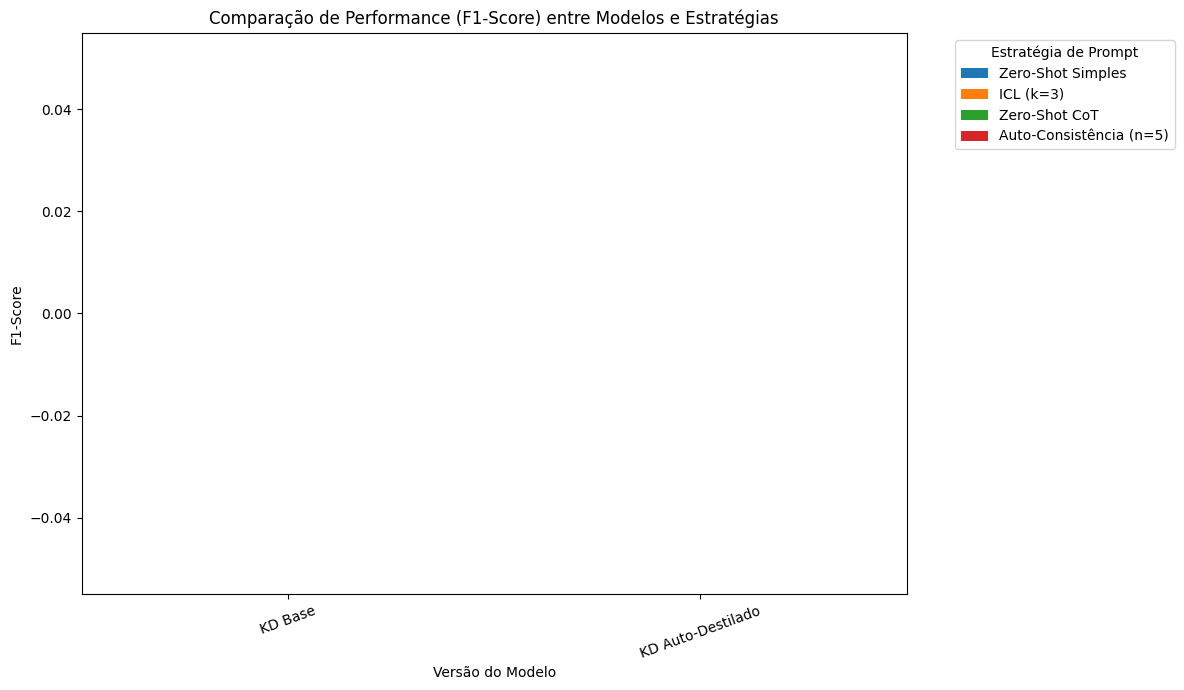

In [17]:

# --- RELATÓRIO FINAL ---
print("\n\n## Relatório Final de Análise ##")
numeric_df = results_df.applymap(lambda x: float(x.split('/')[0]) if isinstance(x, str) else 0)

print("\n--- Matriz de Resultados (F1-Score / Exact Match) ---")
print(results_df.to_markdown())

print("\n--- Conclusões da Análise ---")
print(f"- Melhor Técnica de KD (Média F1): '{avg_kd_performance.idxmax()}' ({avg_kd_performance.max():.2f})")
avg_prompt_performance = numeric_df.mean(axis=0)
print(f"- Melhor Estratégia de Prompting (Média F1): '{avg_prompt_performance.idxmax()}' ({avg_prompt_performance.max():.2f})")
best_combo = numeric_df.stack().idxmax()
print(f"- Melhor Sinergia (Modelo + Prompt): '{best_combo[0]}' + '{best_combo[1]}' com F1 de {numeric_df.max().max():.2f}")

print("\nGerando gráfico de comparação...")
fig, ax = plt.subplots(figsize=(12, 7))
numeric_df.plot(kind='bar', ax=ax, title='Comparação de Performance (F1-Score) entre Modelos e Estratégias')
ax.set_ylabel("F1-Score")
ax.set_xlabel("Versão do Modelo")
ax.tick_params(axis='x', rotation=20)
plt.legend(title='Estratégia de Prompt', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("real_run_full_performance_comparison.png")
print("Gráfico salvo em 'real_run_full_performance_comparison.png'.")